### 1. Import libraries and get data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

In [2]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,1.0100
2017-12-02,0.9959
2017-12-03,0.9977
2017-12-04,1.0000
2017-12-05,1.0000
...,...
2023-03-28,1.0001
2023-03-29,0.9999
2023-03-30,1.0000


Forecasting Horizon Explained

In [3]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

Lag features

In [4]:
def add_lags(df):
    target_map = df['Price'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

### 2. Split the data into training, test and validate sets

In [37]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

In [38]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

In [5]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

train_data = create_features(train_data)
val_data = create_features(val_data)
test_data = create_features(test_data)

Train shape: (1362, 12)
Test shape: (389, 12)
Validate shape: (196, 12)


## 3. Perform XGBoost Model

### 3.1 Build and fit XGBoost Model with train data

In [6]:
features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
target = 'Price'

x_train = train_data[features]
y_train = train_data[target]

x_val = val_data[features]
y_val = val_data[target]

x_test = test_data[features]
y_test = test_data[target]

xgb_model = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

xgb_model.fit(x_train, y_train, eval_set=[(df[features], df[target])], early_stopping_rounds=50, verbose=False)

[01:14:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

### 3.2 Evaluate on Validate data

In [10]:
def evaludate_xgb_model(x_data, y_data):
    predictions = xgb_model.predict(x_data)
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [11]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaludate_xgb_model(x_val, y_val)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data: [1.0008036  1.0014582  1.0014582  1.0008036  1.0004344  1.0002881
 1.0002881  1.0002881  1.0008036  1.0014582  1.0014582  1.0014582
 1.0007329  1.0005574  1.0005574  1.0005574  1.0005574  1.0005574
 1.0005574  1.0012121  0.99991775 0.99978375 0.9989008  0.99895364
 0.99893916 0.99879146 0.9974052  0.9972513  0.9972513  0.9972513
 0.9972513  0.9989083  0.9989083  0.9989083  0.9989083  0.9991871
 0.9991871  0.9991871  0.9982238  0.99971944 1.0006824  0.99971944
 0.99971944 0.99971944 0.99971944 0.99971944 0.99971944 0.9995768
 0.9995768  0.9995768  0.99971944 1.0006824  1.0005956  0.9996327
 1.0005956  1.0005996  1.0004508  1.0004508  1.0004508  0.99891806
 0.9990208  0.9988782  0.9992725  0.99871033 0.99871033 0.99885297
 0.99885297 0.99871033 0.99871033 0.99871033 0.99881464 0.9990463
 0.9990463  0.99918896 0.9990463  0.9992281  0.9990854  0.99911416
 0.9990463  0.9990463  0.9989693  0.99911195 0.99909407 0.99895144
 0.9991228  0.9989143  0.9990549  0.99

### 3.3 Evaluate on Test data

In [12]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaludate_xgb_model(x_test, y_test)

print("Price predict on test data:", y_pred_test)

Price predict on test data: [1.0002881  1.0002881  1.0002153  1.0002153  1.0002153  1.0002153
 1.0002881  1.0002881  1.0002842  1.0002842  1.0002114  1.0002153
 1.0002842  1.0002881  1.0002153  1.0002881  1.0002153  1.0002153
 1.0007305  1.0002881  1.0008036  1.0002881  1.0002153  1.0004344
 1.0002153  1.0002153  1.0002881  1.0002153  1.0007305  1.0002153
 1.0002114  1.0002114  1.0002114  1.0002153  1.0002153  1.0002153
 1.0001445  0.9999697  0.9999697  0.9999659  0.9999697  1.0004845
 1.0000422  0.9999659  0.99951077 0.9987025  0.9973503  0.997517
 0.9974334  0.9975495  0.9962263  0.9960723  0.9960723  0.9960723
 0.9960723  0.9977293  0.9977293  0.9977293  0.9977293  0.99800813
 0.9982238  0.99808115 0.9981508  0.9996464  1.0006824  0.9995038
 1.0006824  1.0006824  0.9996464  0.99971944 0.9995768  1.0006824
 1.0006824  0.9995768  0.9995038  0.99971944 0.9994901  0.9994901
 0.9996327  1.0005996  1.0004508  0.9987807  0.9988537  0.9987024
 1.0006181  0.99894786 0.99878    1.0013535  1.0

### 3.4 Predict price for the next 30 days

In [15]:
future_range = pd.date_range(start=df.index[-1], periods=30, freq='D')
future_df = pd.DataFrame(index=future_range)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()


# Predict the closing prices for the next 30 days
y_next_30_days = xgb_model.predict(future_w_features[features])

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1.0012428 1.002599  1.002599  1.002599  1.0017623 1.002599  1.0017623
 1.0017623 1.0017623 1.0017623 1.002599  1.002599  1.002599  1.002599
 1.002599  1.0017623 1.002599  1.002599  1.002599  1.002599  1.002599
 1.002599  1.002599  1.002599  1.002599  1.002599  1.002599  1.0035511
 1.0017623 1.0035511]


In [16]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

               MSE       MAE      MAPE      RMSE
Validate  0.000002  0.001053  0.001052  0.001361
Test      0.000002  0.001188  0.001188  0.001446


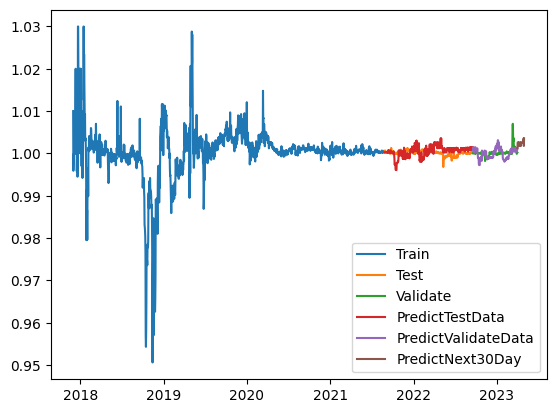

In [17]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()